<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/test/Distributed_Learning_Project5_HYPERPARAMSFINDING_ANDREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install torch and torchvi

In [1]:
!pip install torch torchvision matplotlib
!pip install --upgrade torch torchvision

# install dataset CIFAR-100

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Split training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



100%|██████████| 169M/169M [00:03<00:00, 43.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import math

# Data preprocessing
class Cutout(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img)

        h, w = img.shape[:2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.size // 2, 0, h)
        y2 = np.clip(y + self.size // 2, 0, h)
        x1 = np.clip(x - self.size // 2, 0, w)
        x2 = np.clip(x + self.size // 2, 0, w)
        mask[y1: y2, x1: x2] = 0
        img = img * mask[:, :, np.newaxis]

        return Image.fromarray(np.uint8(img))

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    Cutout(size=8),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def load_cifar100():
    """Load and prepare CIFAR-100 dataset"""
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Layer convolutivi
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)  # 3 input channels, 64 output channels
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)  # 64 input channels, 64 output channels

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)  # Dimensione calcolata per input 32x32 con due conv e max-pooling
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)  # Classificatore lineare per CIFAR-100

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Classificatore lineare
        x = self.fc3(x)

        # Softmax per probabilità
        x = F.log_softmax(x, dim=1)
        return x


def check_initial_loss(model, train_loader, device):
    """Step 1: Check initial loss at initialization"""
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        expected_loss = math.log(100)
        print(f"Initial loss: {loss.item():.4f}")
        print(f"Expected loss: {expected_loss:.4f}")
        return abs(loss.item() - expected_loss) < 1.0

def overfit_small_sample(model, train_loader, device, max_iterations=1000):
    """Step 2: Overfit a small sample"""
    # Get small sample (5 minibatches)
    small_dataset = []
    for i, (inputs, labels) in enumerate(train_loader):
        if i >= 5:
            break
        small_dataset.extend(list(zip(inputs, labels)))

    small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=64, shuffle=True)

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()

    for iteration in range(max_iterations):
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in small_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        avg_loss = total_loss / len(small_loader)

        if iteration % 50 == 0:
            print(f"Iteration {iteration}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if accuracy > 99:
            print("Successfully overfit small sample!")
            return True

    return False

def find_initial_lr(model, train_loader, device, lrs=[1e-1, 1e-2, 1e-3, 1e-4]):
    """Step 3: Find LR that makes loss go down"""
    best_lr = None
    min_loss_decrease = float('inf')

    for lr in lrs:
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5, momentum=0.9)
        initial_loss = None
        final_loss = None

        print(f"\nTrying learning rate: {lr}")

        for iteration in range(100):
            inputs, labels = next(iter(train_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            if iteration == 0:
                initial_loss = loss.item()
            final_loss = loss.item()

            loss.backward()
            optimizer.step()

            if iteration % 20 == 0:
                print(f"Iteration {iteration}, Loss: {loss.item():.4f}")

        loss_decrease = initial_loss - final_loss
        print(f"Loss decrease: {loss_decrease:.4f}")

        if loss_decrease > 0 and loss_decrease < min_loss_decrease:
            min_loss_decrease = loss_decrease
            best_lr = lr

    return best_lr

def coarse_grid_search(model, train_loader, val_loader, device, best_lr):
    """Step 4: Coarse grid search"""
    lrs = [best_lr / 2, best_lr, best_lr * 2]
    weight_decays = [0, 1e-5, 1e-4]
    momentum_arr = [0.9, 0.95]
    results = []

    for lr in lrs:
        for wd in weight_decays:
            momentum = random.choice(momentum_arr)
            print(f"\nTrying LR: {lr}, Weight Decay: {wd}")
            model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

            train_losses = []
            val_accuracies = []

            for epoch in range(5):
                # Training
                model.train()
                total_loss = 0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = F.cross_entropy(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()

                train_losses.append(total_loss / len(train_loader))
                val_accuracies.append(100. * correct / total)

                print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

            results.append({
                'lr': lr,
                'weight_decay': wd,
                'final_loss': train_losses[-1],
                'final_val_acc': val_accuracies[-1],
                'momentum': momentum
            })

    results.sort(key=lambda x: x['final_val_acc'], reverse=True)
    return results[0]

def train_model_with_early_stopping(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs, device, patience=5):
    """Train model with early stopping"""
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

def main():
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CIFAR-100 data
    train_loader, val_loader, test_loader = load_cifar100()

    # Initialize model
    model = LeNet5().to(device)

    # Step 1: Check initial loss
    if check_initial_loss(model, train_loader, device):
        print("Initial loss check passed.")

    # Step 2: Overfit small sample
    if overfit_small_sample(model, train_loader, device):
        print("Successfully overfit small sample.")

    # Step 3: Find learning rate
    best_lr = find_initial_lr(model, train_loader, device)
    print(f"Best learning rate: {best_lr}")

    # Step 4: Coarse grid search for LR and weight decay
    best_model_params = coarse_grid_search(model, train_loader, val_loader, device, best_lr)
    print(f"Best model parameters: {best_model_params}")

    for improvement in range(1, 3):
      # Step 5: Refine grid search and train for longer
      # Train with the best parameters found
      best_lr = best_model_params['lr']
      best_weight_decay = best_model_params['weight_decay']
      model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
      optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=best_model_params['momentum'])
      scheduler = CosineAnnealingLR(optimizer, T_max=5)

      # Train the model for 10-20 epochs
      model, train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_early_stopping(
          model, optimizer, F.cross_entropy, scheduler, train_loader, val_loader, num_epochs=20*improvement, device=device, patience=5
      )

      # Step 6: Look at learning curves
      # Plot training and validation losses and accuracies
      import matplotlib.pyplot as plt
      epochs = range(1, len(train_losses) + 1)

      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_losses, label="Train Loss")
      plt.plot(epochs, val_losses, label="Validation Loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, train_accuracies, label="Train Accuracy")
      plt.plot(epochs, val_accuracies, label="Validation Accuracy")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend()

      plt.tight_layout()
      plt.show()

if __name__ == "__main__":
    main()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Initial loss: 4.6083
Expected loss: 4.6052
Initial loss check passed.
Iteration 0, Loss: 4.6058, Accuracy: 1.25%
Iteration 50, Loss: 0.2299, Accuracy: 93.75%
Successfully overfit small sample!
Successfully overfit small sample.

Trying learning rate: 0.1
Iteration 0, Loss: 4.6034
Iteration 20, Loss: 4.6077
Iteration 40, Loss: 4.5941
Iteration 60, Loss: 4.6040
Iteration 80, Loss: 4.5284
Loss decrease: 0.0971

Trying learning rate: 0.01
Iteration 0, Loss: 4.5960
Iteration 20, Loss: 4.6093


KeyboardInterrupt: 

# Centralized baseline


Using Best Hyperparameters: {'lr': 0.01, 'weight_decay': 0.005, 'momentum': 0.9, 'patience': 100}
Epoch 1/150 | Train Loss: 4.4263, Train Acc: 3.25% | Val Loss: 4.1768, Val Acc: 5.82%
Epoch 2/150 | Train Loss: 4.0686, Train Acc: 7.27% | Val Loss: 3.9643, Val Acc: 8.98%
Epoch 3/150 | Train Loss: 3.9072, Train Acc: 9.68% | Val Loss: 3.8534, Val Acc: 10.35%
Epoch 4/150 | Train Loss: 3.7743, Train Acc: 11.91% | Val Loss: 3.6889, Val Acc: 13.90%
Epoch 5/150 | Train Loss: 3.6731, Train Acc: 13.49% | Val Loss: 3.6848, Val Acc: 13.81%
Epoch 6/150 | Train Loss: 3.6024, Train Acc: 14.69% | Val Loss: 3.5974, Val Acc: 14.26%
Epoch 7/150 | Train Loss: 3.5369, Train Acc: 15.63% | Val Loss: 3.5276, Val Acc: 16.08%
Epoch 8/150 | Train Loss: 3.4830, Train Acc: 16.61% | Val Loss: 3.4651, Val Acc: 17.25%
Epoch 9/150 | Train Loss: 3.4357, Train Acc: 17.54% | Val Loss: 3.4526, Val Acc: 17.49%
Epoch 10/150 | Train Loss: 3.3845, Train Acc: 18.42% | Val Loss: 3.4504, Val Acc: 17.88%
Epoch 11/150 | Train Loss

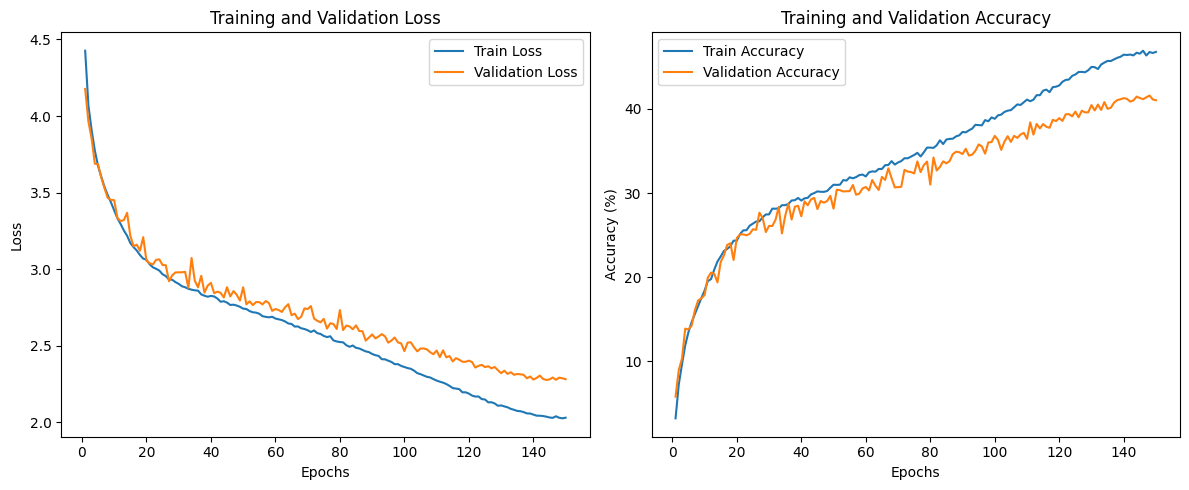

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        #if self.verbose:
        #    print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        #torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Layer convolutivi
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)  # 3 input channels, 64 output channels
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)  # 64 input channels, 64 output channels

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)  # Dimensione calcolata per input 32x32 con due conv e max-pooling
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)  # Classificatore lineare per CIFAR-100

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Classificatore lineare
        x = self.fc3(x)

        # Softmax per probabilità
        x = F.log_softmax(x, dim=1)
        return x



# Centralized baseline training function
def train_model_with_hyperparams(train_loader, val_loader, test_loader, best_hyperparams, num_epochs, device):
    model = LeNet5().to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=best_hyperparams['lr'],
        momentum=best_hyperparams['momentum'],
        weight_decay=best_hyperparams['weight_decay']
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=best_hyperparams.get('patience', 5), verbose=True)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast(device_type=device.type):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load the best model
    #model.load_state_dict(torch.load('checkpoint.pt'))

    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(device_type=device.type):
                outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use the best hyperparameters from random search
    best_hyperparams = {
        'lr': 0.01,
        'weight_decay': 0.005,
        'momentum': 0.9,
        'patience': 100
    }

    print("\nUsing Best Hyperparameters:", best_hyperparams)

    # Train with the best hyperparameters
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        best_hyperparams=best_hyperparams,
        num_epochs=150,
        device=device
    )

    # Plot results
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


save_path = '/content/drive/My Drive/Colab Notebooks/'

plt.savefig(save_path + 'training_results.png')
print("Training results saved to Google Drive as 'training_results.png'")

with open(save_path + 'training_summary.txt', 'w') as f:
    f.write(f"Final Test Accuracy: {test_acc:.2f}%\n")
    f.write("Training and Validation Results:\n")
    f.write(f"Train Losses: {train_losses}\n")
    f.write(f"Validation Losses: {val_losses}\n")
    f.write(f"Train Accuracies: {train_accuracies}\n")
    f.write(f"Validation Accuracies: {val_accuracies}\n")
print("Training summary saved to Google Drive as 'training_summary.txt'")

torch.save(model.state_dict(), save_path + 'best_model.pth')
print("Model saved to Google Drive as 'best_model.pth'")
